# ML project

### imports and aux functions

In [11]:
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from dataretrieval import nwis, utils, codes
#sns.set_style("whitegrid")
sns.set_style("darkgrid")


In [2]:
def percentiles(df=pd.DataFrame, label="wl", show = True, plot=True,station_name="", percents=[]):
    """Get 10% percentile distribution and plot it. Percentiles can be provided """
    q10 = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    if percents:
        q10 = percents
    p10 = df[label].quantile(q10)
    if show:
        print(station_name+" percentile distribution of "+label)
        print(p10)
    if plot:
        plt.figure()
        plt.plot(p10,q10)
        plt.title(station_name+" "+label+" distribution")
    return p10

def custom_plot(df=pd.DataFrame, xtag="", ytag="", 
                kind="scatter",legend=None, title="",
                xlabel="time", ylabel="discharge CFS",
                s=1, xsize=8, ysize=2, date_format="",
                label=""):
    """For my repetitive plotting of dfs or series objects"""
    if date_format != "":
        date_form = DateFormatter(date_format)
    l_param={
        "kind" : kind, 
        "title" : title,
        "xlabel" : xlabel,
        "ylabel" : ylabel, 
        "legend" : legend,
        "label" : label
    }
    if type(df)==pd.DataFrame:
        l_param["x"] = xtag
        l_param["y"] = ytag
    else:
        l_param["kind"]="line"
    if l_param["kind"]=="scatter":
        l_param["s"]=s
    print(l_param)
    ax = df.plot(**l_param)
    if date_format != "":
        ax.xaxis.set_major_formatter(date_form)
    plt.gcf().set_size_inches(xsize,ysize)


In [3]:
def cross_corr( df1=pd.DataFrame, df2=pd.DataFrame,
                tag1="", tag2="",
#                start_date, end_date,  # mmm read data?
#                window_size=365,       # should I just use the bounds of the data? 
                shift_range=(-10,10),
                plot = True):
    """
    Cross correlation tool for the project. User is assumed to give dfs 
    with the same (daily time index) timezone
    """

    if df1.index[0].tz != df2.index[0].tz:
        raise(ValueError("time index zone is not the same in both dfs"))

    # get the common range between the time series
    l_date = min(df1.index[0], df2.index[0])
    h_date = max(df1.index[-1], df2.index[-1])

    # for every shift save the cross correlation    
    ccv=[]
    shifts = range(shift_range[0],shift_range[1]+1)
    for i in shifts:
        _df = pd.DataFrame()
        _df["1"] = df1[tag1]
        _df["2"] = df2[tag2].shift(-i)
        ccv.append(_df["1"].corr(_df["2"]))
    
    # plot shift vs cross correlation
    if plot:
        plt.figure()
        plt.scatter(shifts, ccv)
        plt.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.title("Cross correlation function")
        plt.xlabel(f"time lag (days)")
    # save max shift
    maxcv = shifts[np.argmax(ccv)]

    return maxcv, ccv

### testing

{'kind': 'line', 'title': '', 'xlabel': 'time', 'ylabel': 'discharge CFS', 'legend': None, 'label': '07024175'}
{'kind': 'line', 'title': '', 'xlabel': 'time', 'ylabel': 'discharge CFS', 'legend': None, 'label': '07022000'}
{'kind': 'line', 'title': '', 'xlabel': 'time', 'ylabel': 'discharge CFS', 'legend': None, 'label': '03612600'}


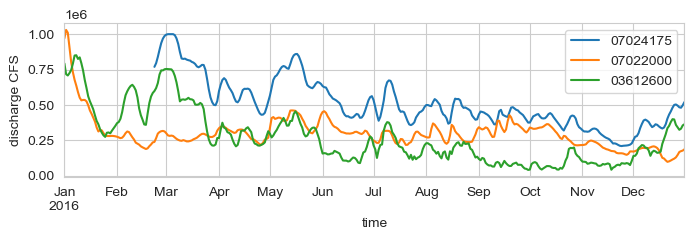

In [4]:
date_format="YYYY-MM-DDTHH:SS:MM"
upstream_sites = ["07022000" , "03612600"]
main_site = "07024175"

param_cd =["00060"] 
param_name = ["mean discharge CFS"]
secondary_param_name = ["water temperature F", "air temperature F",]
secondary_param_cd = ["00011","00021"]


start="2016-01-01"
end="2016-12-31"

dfs=[]

mdf, meta = nwis.get_dv(sites=main_site, start=start, end=end, parameterCd=param_cd)
custom_plot(mdf["00060_Mean"], label=main_site)

for site in upstream_sites:
    df, meta = nwis.get_dv(sites=site, start=start, end=end, parameterCd=param_cd)
    dfs.append(df)
    custom_plot(df["00060_Mean"], label=site)

plt.legend()


{'kind': 'line', 'title': '', 'xlabel': 'time', 'ylabel': 'discharge CFS', 'legend': None, 'label': 'main site'}
{'kind': 'line', 'title': '', 'xlabel': 'time', 'ylabel': 'discharge CFS', 'legend': None, 'label': 'upstream site'}


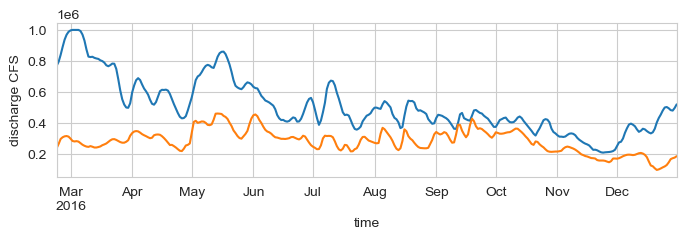

In [16]:
# merging two dfs by intersecting their date indices
joint = pd.merge(mdf,dfs[0],how="inner",left_index=True, right_index=True)
custom_plot(joint["00060_Mean_x"], label="main site")
custom_plot(joint["00060_Mean_y"], label="upstream site")

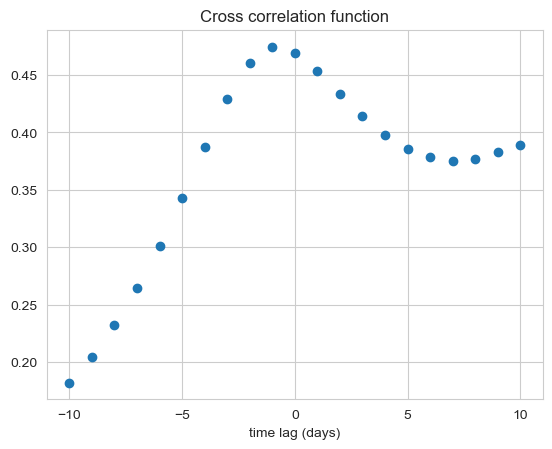

In [13]:
max_lag, corrs = cross_corr(mdf, dfs[0], tag1="00060_Mean", tag2="00060_Mean", shift_range=(-10,10))

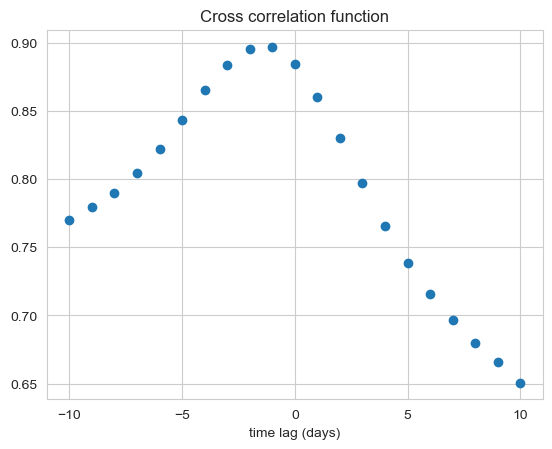

In [16]:
max_lag, corrs =cross_corr(mdf, dfs[1], tag1="00060_Mean", tag2="00060_Mean", shift_range=(-10,10))

{'kind': 'line', 'title': '', 'xlabel': 'time', 'ylabel': 'discharge CFS', 'legend': None}
{'kind': 'line', 'title': '', 'xlabel': 'time', 'ylabel': 'discharge CFS', 'legend': None}
I did came in
{'kind': 'scatter', 'title': '', 'xlabel': 'new1', 'ylabel': 'new2', 'legend': None, 'x': 'new1', 'y': 'new2', 's': 1}


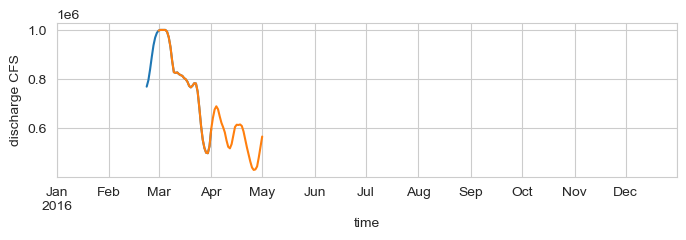

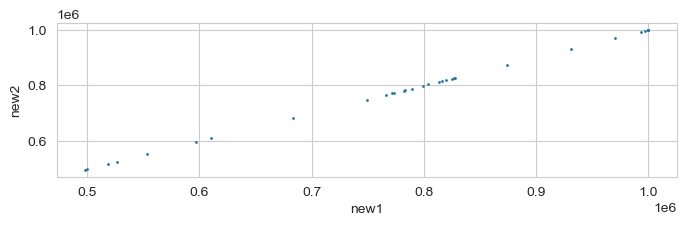

In [88]:
# df, _ = nwis.get_dv(sites=main_site, start="2016-01-01",end="2017-01-01", parameterCd=param_cd)
testdf= pd.DataFrame(index=pd.date_range(start="2016-01-01", end="2016-12-31",freq="D", tz=df.index[0].tz))
testdf["new1"]=df["00060_Mean"]["2016-01-25":"2016-04-01"]
testdf["new2"]=df["00060_Mean"]["2016-03-01":"2016-05-01"]

#print(testdf["new1"].values)
#print(testdf["new2"].values)

custom_plot(testdf["new1"])
custom_plot(testdf["new2"])
custom_plot(testdf, xtag="new1", ytag="new2", xlabel="new1", ylabel="new2")

In [77]:
print(df.index[0].tz)
print(testdf.index[53])
print(df.index[0]-testdf.index[53])

UTC
2016-02-23 00:00:00+00:00
0 days 00:00:00


'# initializing a figure in\n# which the graph will be plotted\nfig = plt.figure()\n\n# fixing the x-axis and y-axis\naxis = plt.axes(xlim =(0, 25),\n\t\t\t\tylim =(0, 4))\n\n# initializing a line variable\nline1, = axis.plot([], [], lw = 3)\nline2, = axis.plot([], [], lw = 3)\ndf=pd.DataFrame()\n# init function for the animation\ndef init():\n\tline1.set_data([], [])\n\tline2.set_data([], [])\n\treturn line1, line2\n\ndef animate(i):\n    n = min( len(yyy["b"].values), len(xxx["a"].shift(-i).values) )\n    x1=range(i,i+n)\n    y1=xxx["a"].shift(-i).values\n    x2=range(n)\n    y2=yyy["b"].values\n    df["1"] = y2\n    df["2"] = y1\n    ccr =df["1"].corr(df["2"])\n    plt.title(f"cross correlation {ccr: .4f}" )\n\t# plots\n    line1.set_data(x1,y1)\n    line2.set_data(x2,y2)\n    return line1, line2\n\nanim = FuncAnimation(fig, animate, init_func = init,\n\t\t\t\t\tframes = list(range(10)), interval = 50, blit = True)\n\n\nanim.save(\'crosscorr.gif\', fps = 2)\n'

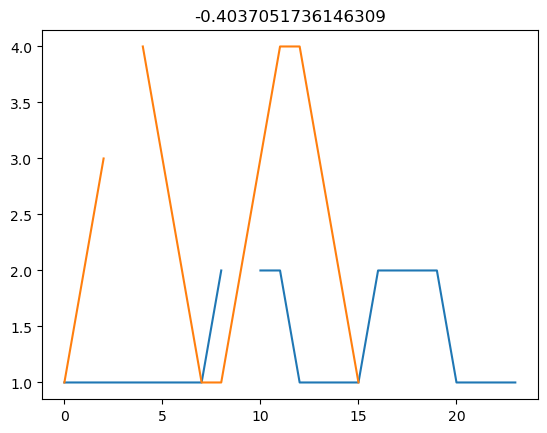

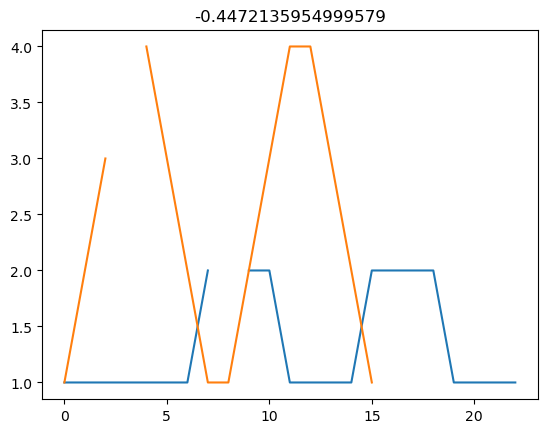

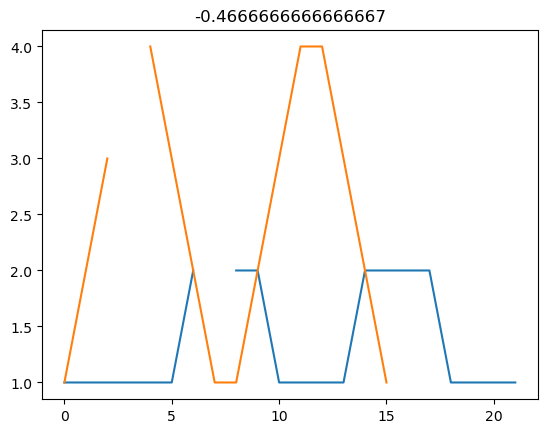

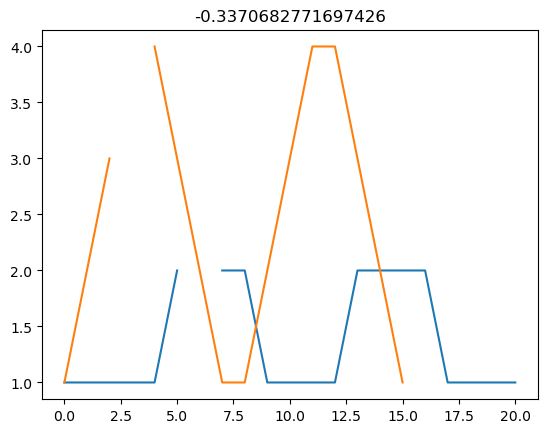

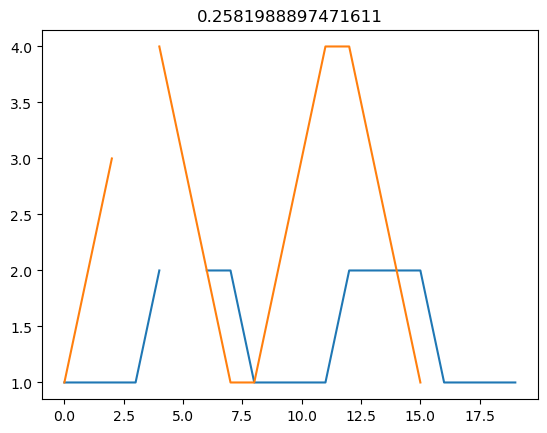

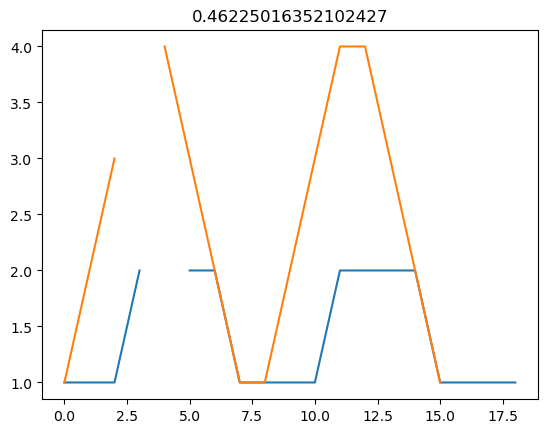

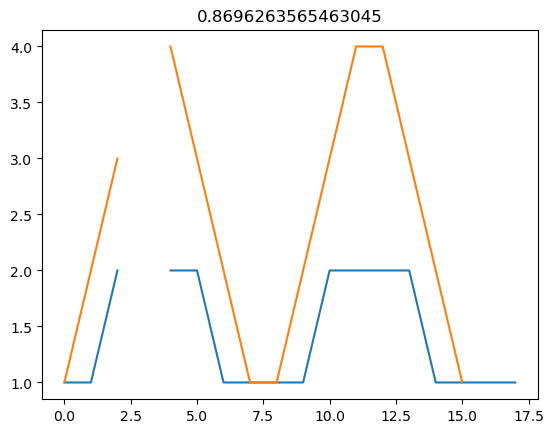

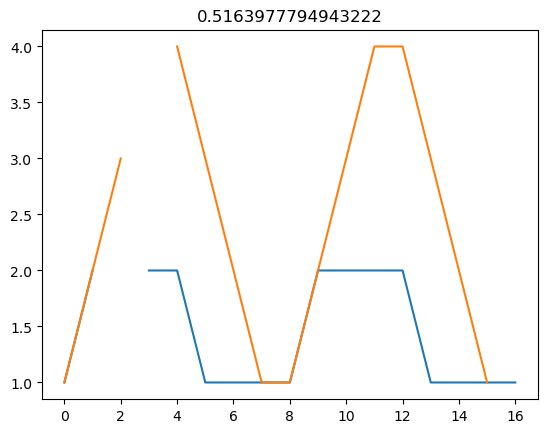

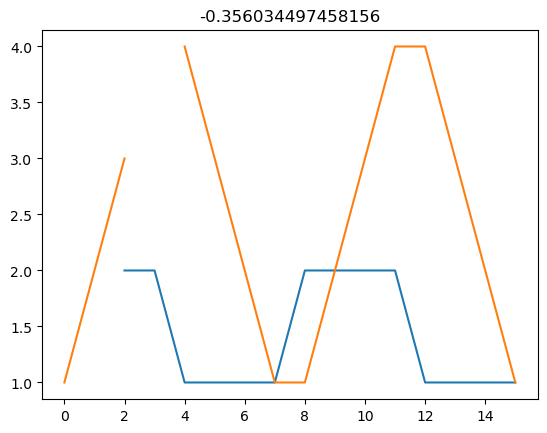

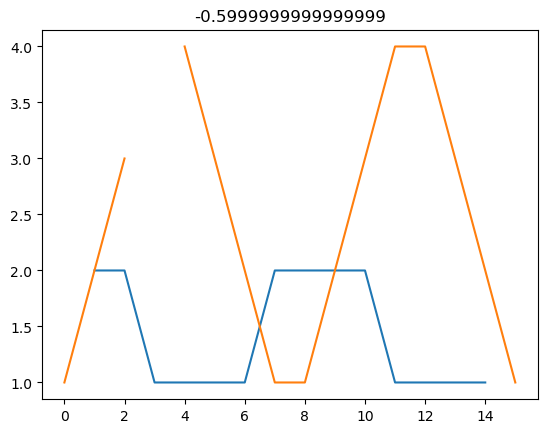

In [1]:
# graph for the cross correlation
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

xxx=pd.DataFrame()
yyy=pd.DataFrame()
xxx["a"]=[1,1,1,1,1,1,1,1,2,None,2,2,1,1,1,1,2,2,2,2,1,1,1,1]
yyy["b"]=[1,2,3,None,4,3,2,1,1,2,3,4,4,3,2,1]
n=10

for i in range(10):
    plt.figure()
    xxx["a"].shift(-i).plot()
    yyy["b"].plot()
    df=pd.DataFrame()
    df["1"] = yyy["b"][0:n].values
    df["2"] = xxx["a"].shift(-i)[0:n].values
    plt.title(df["1"].corr(df["2"]))

"""# initializing a figure in
# which the graph will be plotted
fig = plt.figure()

# fixing the x-axis and y-axis
axis = plt.axes(xlim =(0, 25),
				ylim =(0, 4))

# initializing a line variable
line1, = axis.plot([], [], lw = 3)
line2, = axis.plot([], [], lw = 3)
df=pd.DataFrame()
# init function for the animation
def init():
	line1.set_data([], [])
	line2.set_data([], [])
	return line1, line2

def animate(i):
    n = min( len(yyy["b"].values), len(xxx["a"].shift(-i).values) )
    x1=range(i,i+n)
    y1=xxx["a"].shift(-i).values
    x2=range(n)
    y2=yyy["b"].values
    df["1"] = y2
    df["2"] = y1
    ccr =df["1"].corr(df["2"])
    plt.title(f"cross correlation {ccr: .4f}" )
	# plots
    line1.set_data(x1,y1)
    line2.set_data(x2,y2)
    return line1, line2

anim = FuncAnimation(fig, animate, init_func = init,
					frames = list(range(10)), interval = 50, blit = True)


anim.save('crosscorr.gif', fps = 2)
"""

In [5]:
# merging all data into 1 df
from sklearn.linear_model import LinearRegression

date_format="YYYY-MM-DDTHH:SS:MM"
upstream_sites = ["07022000" , "03612600"]
main_site = "07024175"

param_cd =["00060"] 
param_name = ["mean discharge CFS"]
secondary_param_name = ["water temperature F", "air temperature F",]
secondary_param_cd = ["00011","00021"]


start="2016-01-01"
end="2016-12-31"

# main df
mdf, meta = nwis.get_dv(sites=main_site, start=start, end=end, parameterCd=param_cd)
mdf.drop(columns=["00060_Mean_cd","site_no"], inplace=True)
mdf.rename(columns={"00060_Mean":main_site}, inplace=True)
# adding the upstream sites
dfs=[]
for site in upstream_sites:
    df, meta = nwis.get_dv(sites=site, start=start, end=end, parameterCd=param_cd)
    df.drop(columns=["00060_Mean_cd","site_no"], inplace=True)
    df.rename(columns={"00060_Mean":site}, inplace=True)
    mdf = pd.merge(mdf,df,how="inner",left_index=True, right_index=True)

display(mdf)

,07024175,07022000,03612600
datetime,,,
2016-02-23 00:00:00+00:00,769000.0,238000.0,598000.0
2016-02-24 00:00:00+00:00,795000.0,265000.0,619000.0
2016-02-25 00:00:00+00:00,839000.0,297000.0,654000.0
2016-02-26 00:00:00+00:00,890000.0,308000.0,715000.0
2016-02-27 00:00:00+00:00,937000.0,314000.0,744000.0
...,...,...,...
2016-12-27 00:00:00+00:00,495000.0,146000.0,342000.0
2016-12-28 00:00:00+00:00,483000.0,167000.0,324000.0
2016-12-29 00:00:00+00:00,480000.0,173000.0,332000.0


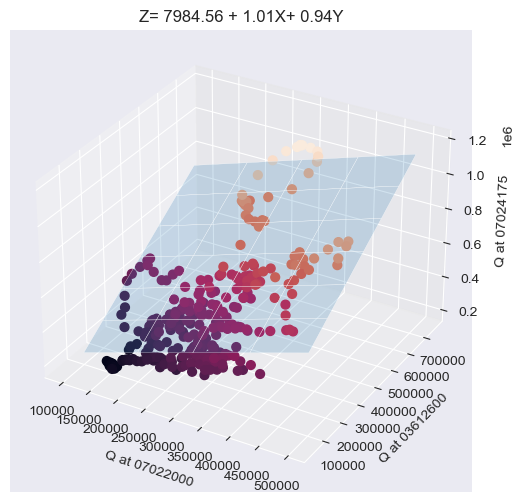

In [55]:
X = mdf[upstream_sites].to_numpy()
y = mdf[main_site].to_numpy()
reg = LinearRegression() 
reg.fit(X,y)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X[:,0], X[:,1], y, s=40, c=y, marker='o', alpha=1)
ax.set_xlabel("Q at "+upstream_sites[0])
ax.set_ylabel("Q at "+upstream_sites[1])
ax.set_zlabel("Q at "+main_site)
ax.set_title(f"Z= {reg.intercept_:.2f} + {reg.coef_[0]:.2f}X+ {reg.coef_[1]:.2f}Y")

# Plot a 3D surface
xs = np.arange(100000,500001,100000)
ys = np.arange(100000,700001,100000)
xx, yy = np.meshgrid(xs,ys)
zz = reg.intercept_+reg.coef_[0]*xx+reg.coef_[1]*yy
ax.plot_surface(xx,yy,zz, linewidth=0.2, alpha=0.2, antialiased=True)
# Plot data
Z = reg.intercept_+reg.coef_[0]*X[:,0]+reg.coef_[1]*X[:,1]
plt.show()



In [36]:
print(reg.coef_)
print(reg.intercept_)

[1.01040717 0.94476222]
7984.562962571799


In [41]:

# Plot a 3D surface
ax.plot_surface(xx,yy,zz, linewidth=0.2, alpha=0.5, antialiased=True)
plt.show()